In [1]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns

from cue.analysis.analysis import bootstrap_ci

In [2]:
from cue.utils.plotting import *

In [3]:
style()

In [4]:
data = np.load('../psy-work/recognition/result.npz')

In [5]:
list(data.keys())

['noise',
 'ordinal_prob',
 'p_tf_out',
 'trial',
 'distractor_rate',
 'p_pos',
 'p_vhat',
 'positions',
 'p_phat',
 'p_ose',
 'pos_keys',
 'vocab_keys',
 'pos_vectors',
 'seed',
 'recognition_order',
 'vocab_vectors',
 't',
 'min_evidence',
 'p_p',
 'p_ctx_spikes']

In [6]:
raw_spikes = data['p_ctx_spikes']

In [7]:
t = data['t'][0]

In [9]:
recognition_epochs = [list(range(10000 + 20000 + 1000 * i + 1000, 10000 + 20000 + 1000 * (i+1) + 1000)) for i in range(10)]

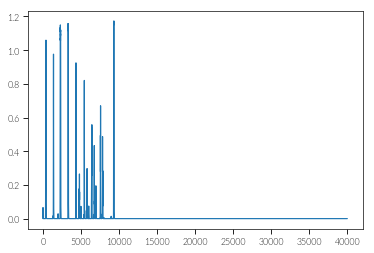

In [6]:
plt.plot(np.linalg.norm(data['p_err'][0], axis=1))

# Context similarity

In [8]:
pi_epochs = [list(range(1000 * i, 1000 * (i+1))) for i in range(10)]

In [9]:
dfs_recall = defaultdict(list)
dfs_pres = defaultdict(list)
for i, trial_data in enumerate(raw_spikes):
    events = list(np.take(trial_data, pi_epochs, axis=0))
    r_pos = []
    
    firing = [np.sum(e, axis=0) / 1000. for e in events]
    z_scores = (firing - np.mean(firing, axis=0, keepdims=1)) / np.std(firing, axis=0, keepdims=1)
    
    for k in range(len(events)):
        df = pd.DataFrame({
            'trial': [i] * 800,
            'unit': range(800),
            'z-score': z_scores[k]
        }).dropna().set_index(['trial', 'unit'])
        if k < 10:
            dfs_pres[k].append(df)
        else:
            dfs_recall[r_pos[k - 10]].append(df)
            
dfs_pres = {k: pd.concat(v) for k, v in dfs_pres.items()}
dfs_recall = {k: pd.concat(v) for k, v in dfs_recall.items()}

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [10]:
def calc_recency_sim(pos):
    similarity = (
        (dfs_pres[9] * dfs_pres[pos]).dropna().groupby('trial').sum() / 800.)['z-score']
    μ = similarity.mean()
    ci_low, ci_up = bootstrap_ci(similarity, np.mean)
    return μ, (μ - ci_low, ci_up - μ)

In [11]:
x = np.arange(10)
recency = x - 9
similarity_mean, similarity_ci = zip(*(calc_recency_sim(a) for a in x))

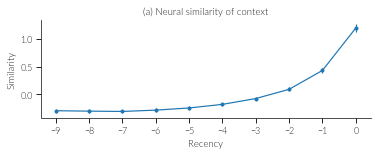

In [12]:
fig = plt.figure(figsize=(textwidth, row_height))

ax = fig.add_subplot(1, 1, 1)
ax.errorbar(recency, similarity_mean, np.asarray(similarity_ci).T, marker='o', markersize=3)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Recency")
ax.set_ylabel("Similarity")
ax.set_title("(a) Neural similarity of context")

sns.despine(fig)
fig.tight_layout()

# Contiguity

In [13]:
def analyze_contiguity(raw_spikes):
    pi_epochs = [list(range(1000 * i, 1000 * (i+1))) for i in range(10)]
    recognition_epochs = [list(range(10000 + 20000 + 1000 * i, 10000 + 20000 + 1000 * (i+1))) for i in range(10)]
    
    def z_score(trial_data, epochs):
        durations = np.diff(np.asarray(epochs)[:, [0, -1]]) + 1.
        events = np.asarray(np.take(trial_data, epochs, axis=0))
        firing = np.sum(events, axis=1) / durations
        z_scores = (firing - np.mean(firing, axis=0, keepdims=1)) / np.std(firing, axis=0, keepdims=1)
        return z_scores

    dfs = []
    event_duration = 1000.
    for i, trial_data in enumerate(raw_spikes):
        a = z_score(trial_data, pi_epochs + recognition_epochs)
        presentation_z_scores = a[:10]
        recognition_z_scores = a[10:]
        #presentation_z_scores = z_score(trial_data, pi_epochs)
        presentation_z_scores = np.nan_to_num(presentation_z_scores, copy=False)
        #recognition_z_scores = z_score(trial_data, recognition_epochs)
        recognition_z_scores = recognition_z_scores[np.argsort(data['recognition_order'][i]), :]
        recognition_z_scores = np.nan_to_num(recognition_z_scores, copy=False)
        similarity = np.dot(presentation_z_scores, recognition_z_scores.T) / presentation_z_scores.shape[1]

        for pres_idx, recog_idx in np.ndindex(*similarity.shape):
            dfs.append(pd.DataFrame({
                'trial': i,
                'lag': pres_idx - recog_idx,
                'similarity': similarity[pres_idx, recog_idx]
            }, index=[0]))
    return pd.concat(dfs).reset_index(drop=True)

In [14]:
def plot_contiguity(ax, df):
    g = df.groupby('lag')
    μ = g.mean()

    ci = np.asarray([bootstrap_ci(x['similarity'], np.mean) for _, x in g])
    ci *= np.array([-1, 1])
    ci += np.array([μ['similarity'], -μ['similarity']]).T
    
    ax.errorbar(μ.index, μ['similarity'], ci.T, fmt='o', markersize=3)

In [15]:
df_cont_ctx = analyze_contiguity(data['p_ctx_spikes'])

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [16]:
df_cont_ose = analyze_contiguity(data['p_ose'])

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


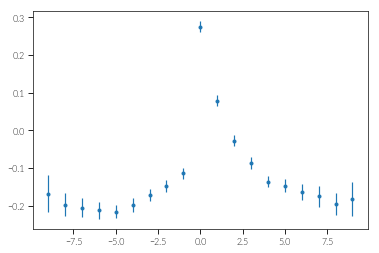

In [17]:
plot_contiguity(plt.gca(), df_cont_ctx)

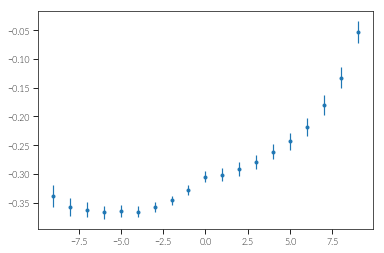

In [18]:
plot_contiguity(plt.gca(), df_cont_ose)

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


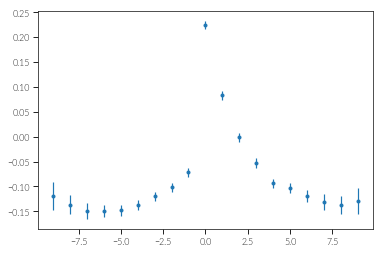

In [20]:
plot_contiguity(plt.gca(), analyze_contiguity(data['p_tf_out']))

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


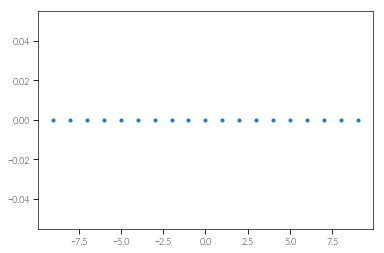

In [21]:
plot_contiguity(plt.gca(), analyze_contiguity(data['p_pos']))

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


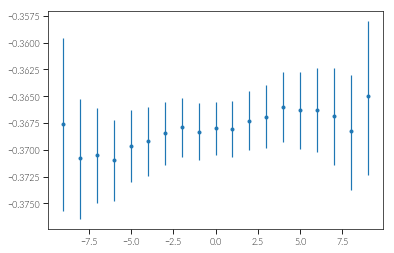

In [22]:
plot_contiguity(plt.gca(), analyze_contiguity(data['p_vhat']))

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


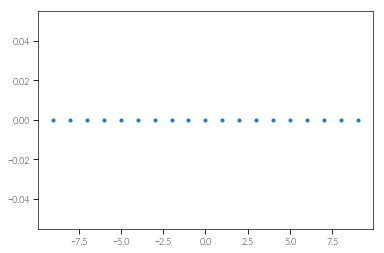

In [23]:
plot_contiguity(plt.gca(), analyze_contiguity(data['p_phat']))

/home/jgosmann/.virtualenvs/cue/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


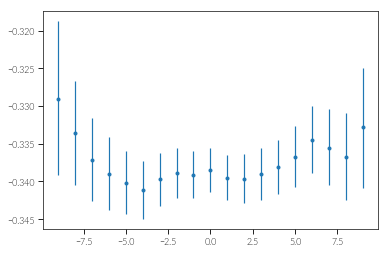

In [24]:
plot_contiguity(plt.gca(), analyze_contiguity(data['p_p']))

# Plot

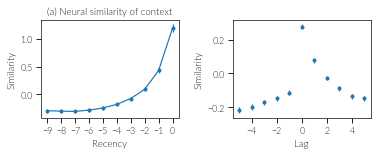

In [25]:
fig = plt.figure(figsize=(textwidth, row_height))

ax = fig.add_subplot(1, 2, 1)
ax.errorbar(recency, similarity_mean, np.asarray(similarity_ci).T, marker='o', markersize=3)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Recency")
ax.set_ylabel("Similarity")
ax.set_title("(a) Neural similarity of context")

ax = fig.add_subplot(1, 2, 2)
plot_contiguity(ax, df_cont_ctx)
ax.set_xlim(-5.5, 5.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Lag")
ax.set_ylabel("Similarity")

sns.despine(fig, top=False, right=False)
fig.tight_layout()

In [26]:
save_tight_fig(fig, './neural-context.pdf')

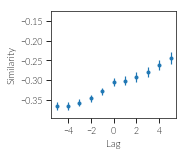

In [27]:
fig = plt.figure(figsize=(textwidth / 2, row_height))

ax = fig.add_subplot(1, 1, 1)
plot_contiguity(ax, df_cont_ose)
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(top=-0.125)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Lag")
ax.set_ylabel("Similarity")

sns.despine(fig, top=False, right=False)
fig.tight_layout()

In [28]:
save_tight_fig(fig, './neural-ose.pdf')